In [1]:
!pip install pandas==2.1.2
!pip install datasets==2.14.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version i

In [2]:
pip install wordcloud


In [3]:
!pip install torchinfo


In [4]:
!pip install matplotlib


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

from torchinfo import summary
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import json

In [6]:
df_train = pd.read_csv("/content/train-2.csv")

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [8]:
df_train.dropna(inplace=True)

In [9]:
df_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [10]:
len(df_train)

27480

In [11]:
df_train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11117


(<Axes: >,
 sentiment
 neutral     11117
 positive     8582
 negative     7781
 Name: count, dtype: int64)

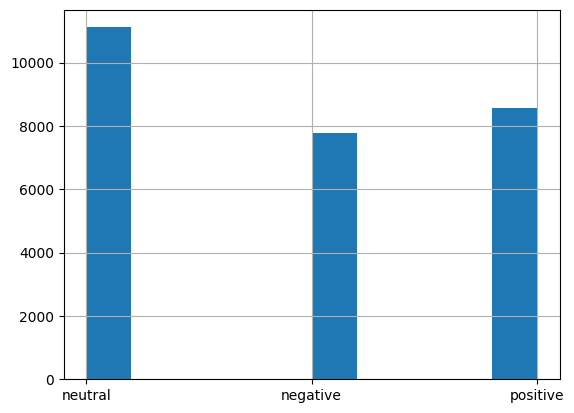

In [12]:
df_train['sentiment'].hist(), df_train['sentiment'].value_counts()

In [13]:

a = df_train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
a.style.background_gradient(cmap='Blues')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


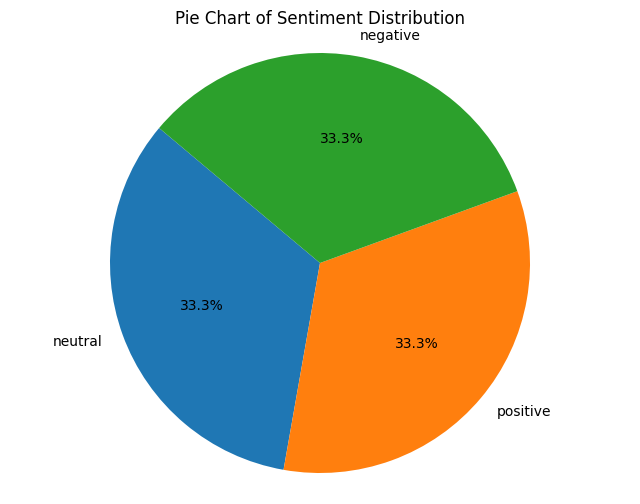

In [14]:
import matplotlib.pyplot as plt

# Calculate sentiment counts
sentiment_counts = a['sentiment'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [15]:
df_test = pd.read_csv('/content/test.csv')
df_ss = pd.read_csv('/content/sample_submission.csv')

In [16]:
df_train.shape


(27480, 4)

In [17]:
df_test.shape

(3534, 3)

In [18]:
df_test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [19]:

df_train.isnull().sum()



textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [20]:
print(df_train['sentiment'].unique())


['neutral' 'negative' 'positive']


In [21]:
# Define a function to calculate Jaccard similarity
def calculate_jaccard_similarity(str1, str2):
    set1 = set(str1.lower().split())
    set2 = set(str2.lower().split())
    intersection = set1.intersection(set2)
    jaccard_similarity = float(len(intersection)) / (len(set1) + len(set2) - len(intersection))
    return jaccard_similarity

# Calculate Jaccard similarity for each row
jaccard_scores = []
for index, row in df_train.iterrows():
    text = row['text']
    selected_text = row['selected_text']
    jaccard_score = calculate_jaccard_similarity(text, selected_text)
    jaccard_scores.append(jaccard_score)

# Add Jaccard similarity scores to the DataFrame
df_train['jaccard_score'] = jaccard_scores



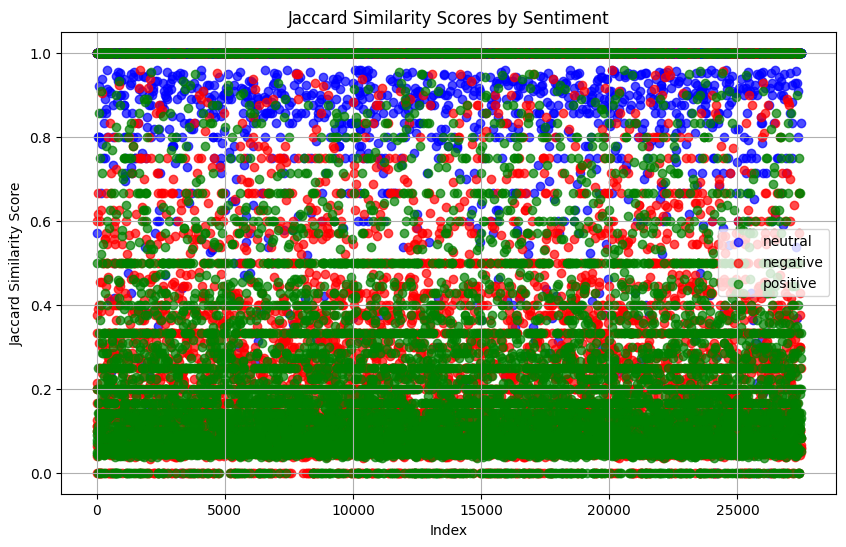

In [22]:
import matplotlib.pyplot as plt

# Define color map for sentiments
color_map = {'neutral': 'blue', 'positive': 'green', 'negative': 'red'}

# Plot scatter plot of Jaccard similarity scores by sentiment
plt.figure(figsize=(10, 6))
for sentiment in df_train['sentiment'].unique():
    sentiment_data = df_train[df_train['sentiment'] == sentiment]
    if not sentiment_data.empty:  # Check if there are data points for the sentiment category
        plt.scatter(sentiment_data.index, sentiment_data['jaccard_score'], color=color_map[sentiment], label=sentiment, alpha=0.7)

plt.title('Jaccard Similarity Scores by Sentiment')
plt.xlabel('Index')
plt.ylabel('Jaccard Similarity Score')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
df_train.head()

,textID,text,selected_text,sentiment,jaccard_score
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286


<ipython-input-24-7dda89ee7a70>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='jaccard_score', data=df_train, palette="Set3")


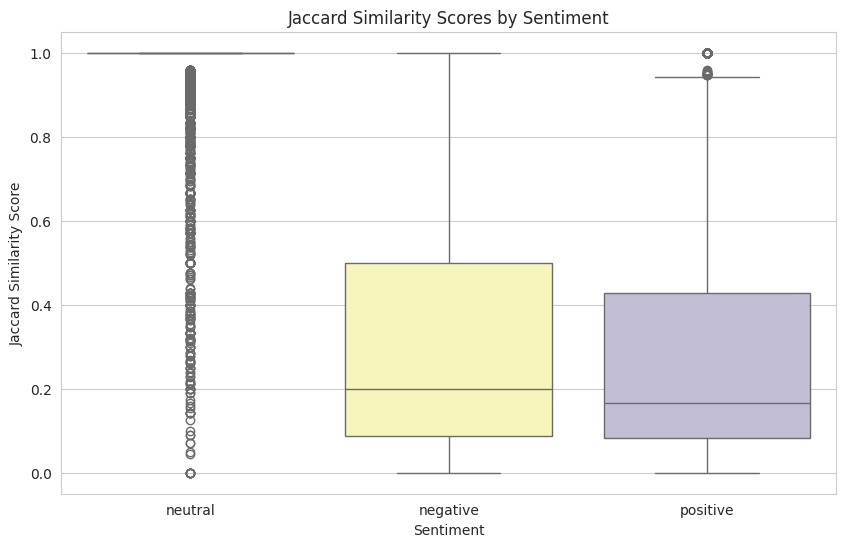

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set_style("whitegrid")

# Plot the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='jaccard_score', data=df_train, palette="Set3")
plt.title('Jaccard Similarity Scores by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Jaccard Similarity Score')
plt.show()


In [25]:
# Number of words in selected text
df_train['Num_words_ST'] = df_train['text'].apply(lambda x: len(str(x).split()))

# Number of words in text
df_train['Num_words_Text'] = df_train['text'].apply(lambda x: len(str(x).split()))

# Difference in number of words in text and selected text
df_train['difference_in_words'] = df_train['Num_words_Text'] - df_train['Num_words_ST']

print(df_train)

           textID                                               text  \
0      cb774db0d1                I`d have responded, if I were going   
1      549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2      088c60f138                          my boss is bullying me...   
3      9642c003ef                     what interview! leave me alone   
4      358bd9e861   Sons of ****, why couldn`t they put them on t...   
...           ...                                                ...   
27476  4eac33d1c0   wish we could come see u on Denver  husband l...   
27477  4f4c4fc327   I`ve wondered about rake to.  The client has ...   
27478  f67aae2310   Yay good for both of you. Enjoy the break - y...   
27479  ed167662a5                         But it was worth it  ****.   
27480  6f7127d9d7     All this flirting going on - The ATG smiles...   

                                           selected_text sentiment  \
0                    I`d have responded, if I were going   neutra

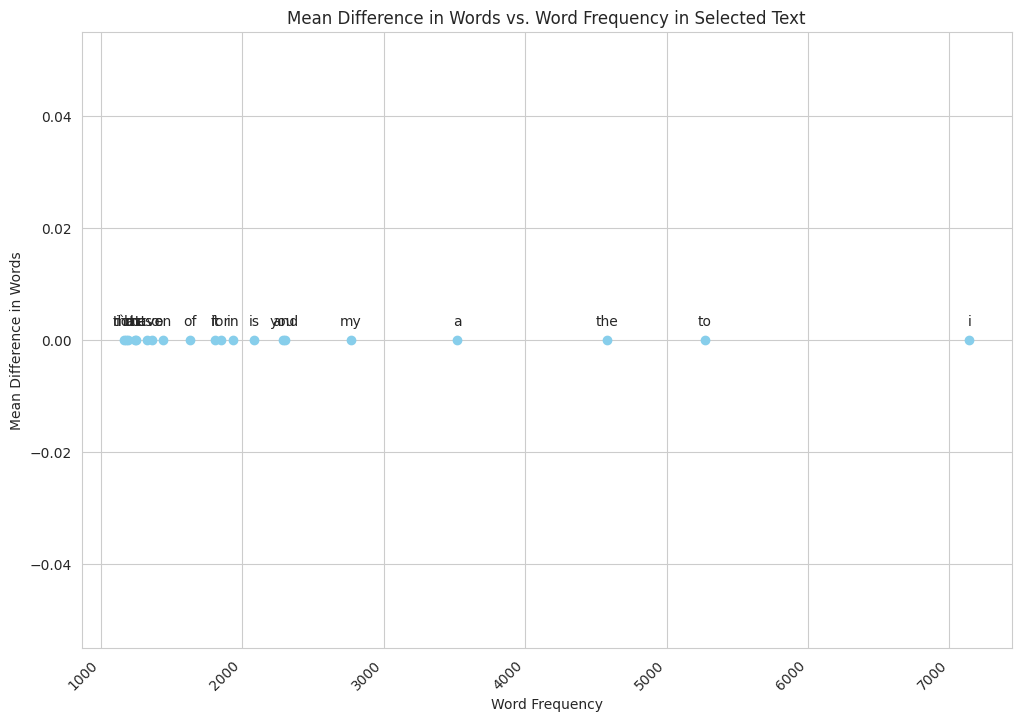

In [26]:
from collections import Counter
import matplotlib.pyplot as plt

# Concatenate selected_text for all sentiments
all_selected_text = ' '.join(df_train['selected_text'])

# Split the text into words and calculate the frequency of each word
selected_text_words = all_selected_text.lower().split()
word_freq = Counter(selected_text_words)

# Filter out common stopwords if necessary
# stopwords = set(nltk.corpus.stopwords.words('english'))
# selected_text_words = [word for word in selected_text_words if word not in stopwords]

# Sort the words by frequency in descending order
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Plot the most common words and their difference in words
num_words_to_plot = 20  # Change this value to plot more or fewer words
top_words = [word for word, freq in sorted_word_freq[:num_words_to_plot]]

# Calculate the mean difference in words for each common word
word_freq_diff = {}
for word in top_words:
    selected_texts_with_word = df_train[df_train['selected_text'].str.lower().str.contains(word)]
    word_freq_diff[word] = selected_texts_with_word['difference_in_words'].mean()

# Create lists to hold word frequency and corresponding mean difference in words
x_values = []
y_values = []
for word in top_words:
    x_values.append(word_freq[word])
    y_values.append(word_freq_diff[word])

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(x_values, y_values, color='skyblue')
plt.title('Mean Difference in Words vs. Word Frequency in Selected Text')
plt.xlabel('Word Frequency')
plt.ylabel('Mean Difference in Words')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
for word, x, y in zip(top_words, x_values, y_values):
    plt.annotate(word, (x, y), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()


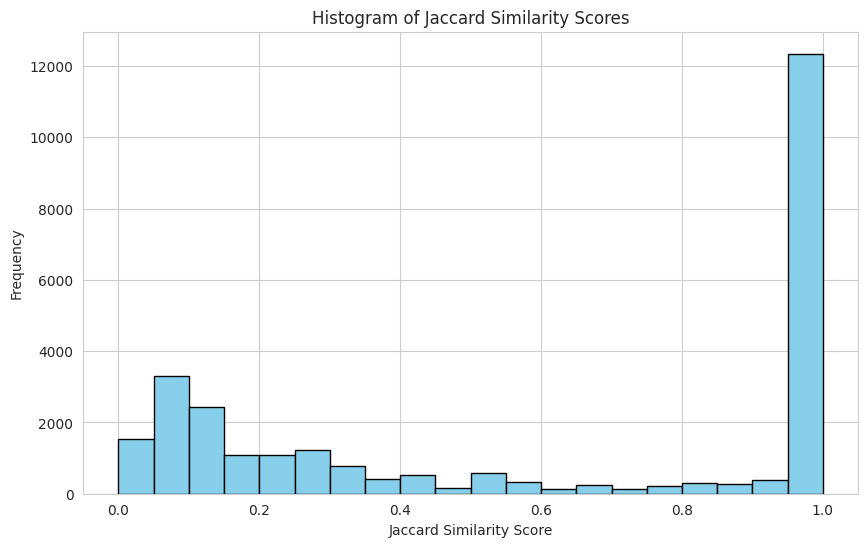

In [27]:
import matplotlib.pyplot as plt

# Create a histogram of Jaccard similarity scores
plt.figure(figsize=(10, 6))
plt.hist(df_train['jaccard_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Jaccard Similarity Scores')
plt.xlabel('Jaccard Similarity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


<ipython-input-28-8ccb4f719a86>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_distribution = df_train.groupby(['sentiment', 'difference_bins']).size().unstack()


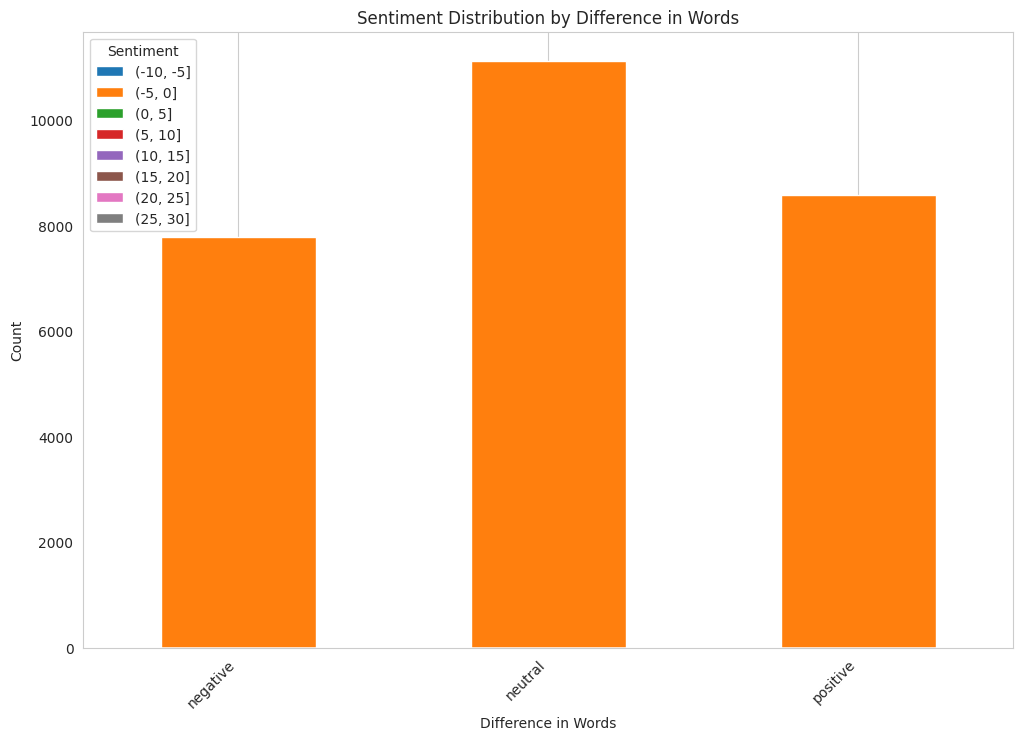

In [28]:
import matplotlib.pyplot as plt

# Define bins for difference in words
bins = [-10, -5, 0, 5, 10, 15, 20, 25, 30]  # Define your own bins/ranges as needed

# Create a new column for binning difference in words
df_train['difference_bins'] = pd.cut(df_train['difference_in_words'], bins)

# Group by sentiment and difference bins, and count occurrences
sentiment_distribution = df_train.groupby(['sentiment', 'difference_bins']).size().unstack()

# Plot stacked bar chart
sentiment_distribution.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Sentiment Distribution by Difference in Words')
plt.xlabel('Difference in Words')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.grid(axis='y')
plt.show()


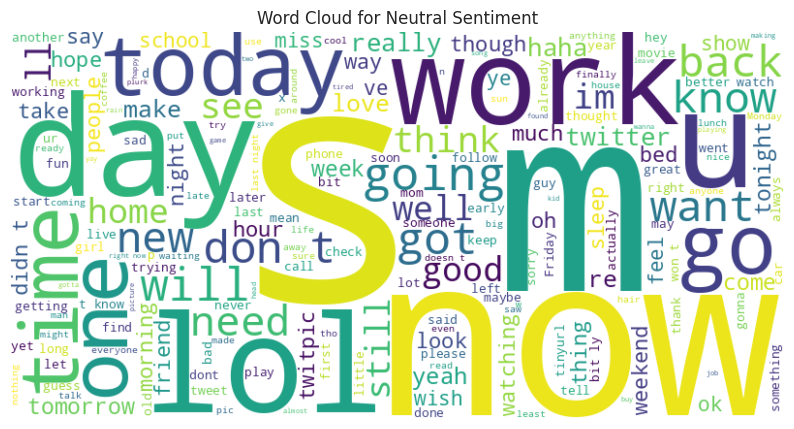

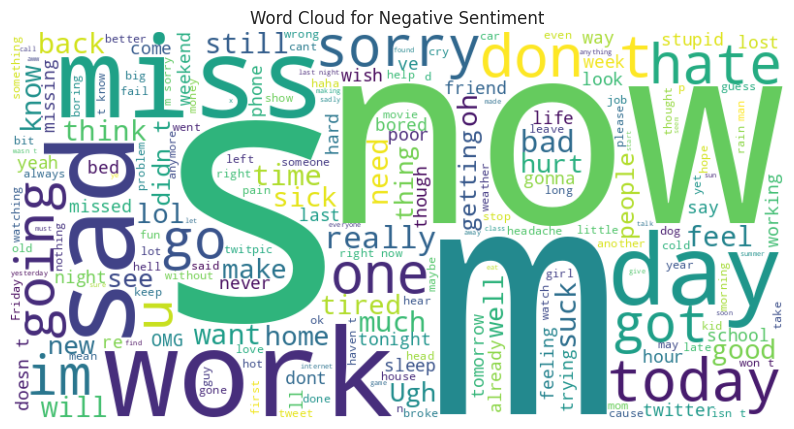

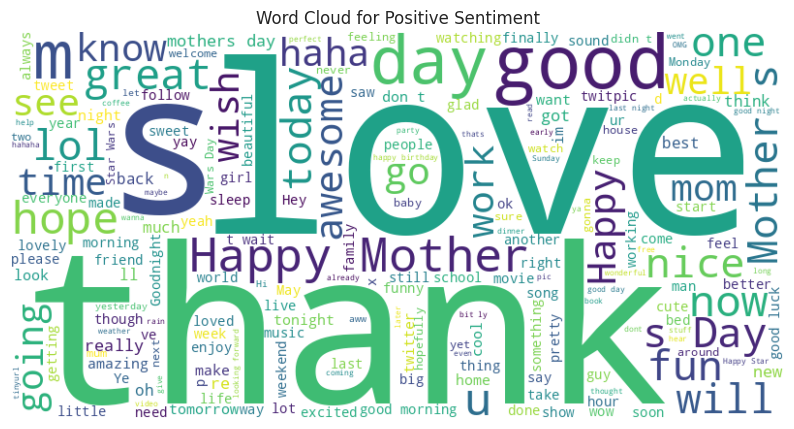

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define a function to generate word clouds
def generate_wordcloud(sentiment):
    # Concatenate selected_text for the given sentiment
    text = ' '.join(df_train[df_train['sentiment'] == sentiment]['text'])

    # Create and generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Word Cloud for ' + sentiment.capitalize() + ' Sentiment')
    plt.axis('off')
    plt.show()

# Generate word clouds for each sentiment category
sentiments = df_train['sentiment'].unique()
for sentiment in sentiments:
    generate_wordcloud(sentiment)
